In [115]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

In [116]:
file_path = 'spec-6476-56358-0650.fits'
t = Table.read(file_path)

t

flux,loglam,ivar,and_mask,or_mask,wdisp,sky,model
float32,float32,float32,int32,int32,float32,float32,float32
36.311607,3.5571,0.02647404,0,0,1.1605932,5.2503796,30.977335
31.581005,3.5572,0.027193226,0,0,1.1607782,4.788879,31.064526
26.368147,3.5573,0.029743887,0,0,1.1602511,4.4398003,30.048332
40.61604,3.5574,0.0244861,0,0,1.1607729,4.3273525,30.219416
40.395905,3.5575,0.026089525,0,0,1.1608392,4.3071427,30.754435
41.02365,3.5576,0.023132984,0,0,1.1604986,4.353813,30.077955
49.249195,3.5577,0.02675654,0,0,1.1592796,4.3352733,29.2201
22.113743,3.5578,0.029651104,0,0,1.1585904,4.4097004,29.513203
47.49873,3.5579,0.024409276,0,0,1.1594409,4.805399,30.52793


# Data

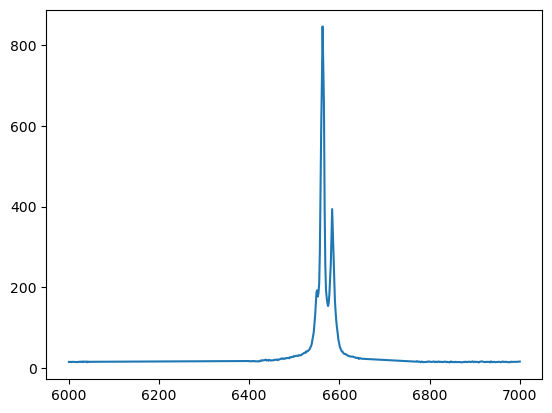

In [139]:
file_path = 'spec-6476-56358-0650.fits'

t = Table.read(file_path)
t.sort('loglam')

z = 0.06342521
wl = (10**t['loglam']) / (1+z)
flux = t['flux']
err = t['ivar']

#flux_lim = np.where(flux>0)[0]
#wl=wl[flux_lim]
#flux=flux[flux_lim]
#err=err[flux_lim]

wl_lim = np.where((wl>6000)&(wl<7000))
wl=wl[wl_lim]
flux=flux[wl_lim]
err=err[wl_lim]

mask1 = np.where((wl<6050)|(wl>6400))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

mask1 = np.where((wl<6650)|(wl>6770))
wl=wl[mask1]
flux=flux[mask1]
err=err[mask1]

plt.plot(wl, flux)
#plt.xlim(5500, 7500)
#plt.ylim(-1, 100)
plt.show()

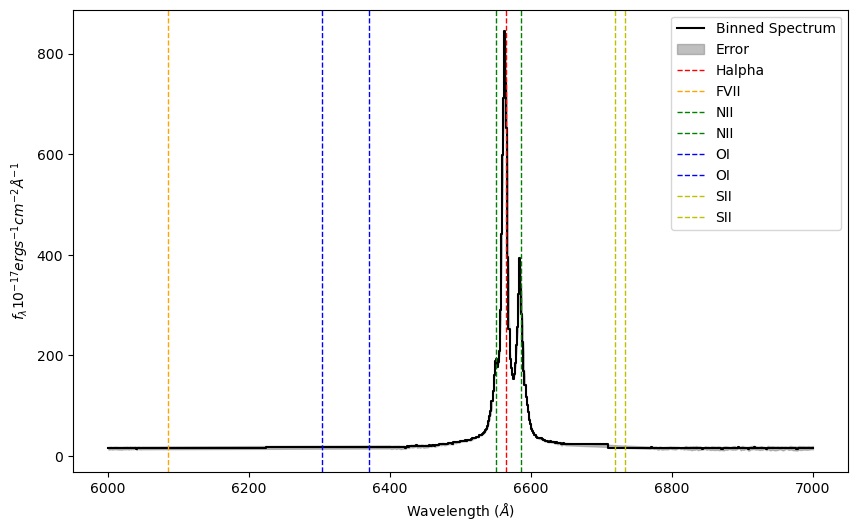

In [140]:
bin_width = 1

bins = np.arange(min(wl), max(wl) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(wl, bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(wl[in_bin]))
        binned_flux.append(np.mean(flux[in_bin]))
        binned_flux_err.append(np.mean(err[in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=6564.93, color='r', linestyle='--', linewidth=1, label="Halpha")
plt.axvline(x=6085.90, color='orange', linestyle='--', linewidth=1, label="FVII")
plt.axvline(x=6551.06, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6585.64, color='g', linestyle='--', linewidth=1, label="NII")
plt.axvline(x=6370, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6303, color='b', linestyle='--', linewidth=1, label="OI")
plt.axvline(x=6719, color='y', linestyle='--', linewidth=1, label="SII")
plt.axvline(x=6734, color='y', linestyle='--', linewidth=1, label="SII")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(5900, 6900)
#plt.ylim(0, 100)
plt.legend()
plt.show()

## Functions

In [141]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [142]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [143]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [160]:
def optical_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                         nii1_f,nii1_cent,nii1_fwhm,\
                        nii2_f,nii2_cent,nii2_fwhm,\
                         halpha1_f,halpha1_cent,halpha1_fwhm,\
                         halpha2_f,halpha2_cent,halpha2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)      
    
    
    nii1 = gaussian(x,nii1_f,nii1_cent,nii1_fwhm,normalized=False)
    nii2 = gaussian(x,nii2_f,nii2_cent,nii2_fwhm,normalized=False)

    
    
    
    # narrow and broad halpha line
    halpha1 = gaussian(x,halpha1_f,halpha1_cent,halpha1_fwhm,normalized=False)
    halpha2 = gaussian(x,halpha2_f,halpha2_cent,halpha2_fwhm,normalized=False)

    y = pl + halpha1 + nii2 + halpha2  + nii1
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             'nii1':nii1,\
            'nii2':nii2,\
            'halpha1':halpha1,\
            'halpha2':halpha2} 
    
    return y

In [161]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [162]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [163]:
def optical_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(optical_agn_spectrum, 14,
            parnames=['pl_s','pl_e',\
                      'nii1_f','nii1_cent','nii1_fwhm',\
                    'nii2_f','nii2_cent','nii2_fwhm',\
                     'halpha1_f','halpha1_cent','halpha1_fwhm',\
                     'halpha2_f','halpha2_cent','halpha2_fwhm'], 
            parlimited=[(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                        (False,False),(False,False),(False,False),\
                       (False,False),(False,False),(False,False),], 
            parlimits=[(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                      (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "optagn"
    
    return myclass

In [164]:
def plot_optical_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    
    halpha1 = model['halpha1']
    halpha2 = model['halpha2'] 
    nii1 = model['nii1']
    nii2 = model['nii2']

    
    
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl']-300,color=royal_blue)
    ax.plot(wave,halpha1-300,color=pink)
    ax.plot(wave,halpha2-300,color=pink)
    ax.plot(wave,nii1-300,color=pink)
    ax.plot(wave,nii2-300,color=pink)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(4700,5100)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_Hbfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    #ax.set_xlim(3715,4450)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_SBfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)

## Setup for plotting

In [165]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [166]:
flux = binned_flux
lam = binned_wl
err = binned_flux_err


In [167]:
sii1 = 6718.85
sii2 = 6733.72
halpha1 = 6564.93
halpha2 = 6584.93
oi2 = 6370.46
oi1 = 6303.05
nii1 = 6551.06
nii2 = 6585.64
nii_off = nii1/nii2
halpha1_off = halpha1/nii2

fvii = 6085.90


c = 2.99e5 # km/s

In [177]:
guesses = [3,0,\
           400, nii2, 800,\
           130, nii1, 400,\
          800, halpha1, 800,\
          50, halpha1, 3000]
           
tied = ['','',\
        '', '', '',\
        #'', '', '',\
        '', 'p[3] * {0}'.format(nii_off), 'p[4]',\
        '', 'p[3] * {0}'.format(halpha_off), 'p[4]',\
       '', '', '',]

step = [0.5, 0.05,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
       0.5, 0.1, 5]

fixed = [0,0,\
         0,0,0,\
          0,0,0,\
         0,0,0,\
        0,0,0]

In [178]:
print(len(guesses))

14


In [179]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux,xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('opticalagn',optical_agn_fitter(),14)
spec.specfit.selectregion(xmin=6000,xmax=7000)
spec.specfit(fittype='opticalagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 0,349 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  1.903898485e+10  DOF =  339
   PL_S0 = 3  
   PL_E0 = 0  
   NII1_F0 = 400  
   NII1_CENT0 = 6585.64  
   NII1_FWHM0 = 800  
   NII2_F0 = 130  
   NII2_CENT0 = 6551.06  
   NII2_FWHM0 = 800  
   HALPHA1_F0 = 800  
   HALPHA1_CENT0 = 6564.93  
   HALPHA1_FWHM0 = 800  
   HALPHA2_F0 = 50  
   HALPHA2_CENT0 = 6564.93  
   HALPHA2_FWHM0 = 3000  
Iter       2    CHI-SQUARE =  8568848457  DOF =  339
   PL_S0 = -20.34149893  
   PL_E0 = 10.00582278  
   NII1_F0 = 444.3279203  
   NII1_CENT0 = 6582.704903  
   NII1_FWHM0 = 512.9252092  
   NII2_F0 = 104.7106073  
   NII2_CENT0 = 6548.140314  
   NII2_FWHM0 = 512.9252092  
   HALPHA1_F0 = 833.9533769  
   HALPHA1_CENT0 = 6562.004133  
   HALPHA1_FWHM0 = 512.9252092  
   HALPHA2_F0 = 32.10099569  
   HALPHA2_CENT0 = 6626.832217  
   HALPHA2_FWHM0 = 3226.412913  
Iter       3    CHI-SQUARE =  2705372297  DOF =  339
   PL_

Iter      26    CHI-SQUARE =  540699088.1  DOF =  339
   PL_S0 = -3574.65821  
   PL_E0 = 10.55166619  
   NII1_F0 = 361.5858893  
   NII1_CENT0 = 6583.919704  
   NII1_FWHM0 = 412.2322784  
   NII2_F0 = 430.0833776  
   NII2_CENT0 = 6549.348737  
   NII2_FWHM0 = 412.2322784  
   HALPHA1_F0 = 824.3068138  
   HALPHA1_CENT0 = 6563.215114  
   HALPHA1_FWHM0 = 412.2322784  
   HALPHA2_F0 = 55.9448951  
   HALPHA2_CENT0 = 6674.407201  
   HALPHA2_FWHM0 = 6476.726566  
Iter      27    CHI-SQUARE =  540318656.5  DOF =  339
   PL_S0 = -3574.122294  
   PL_E0 = 10.57200416  
   NII1_F0 = 358.8953696  
   NII1_CENT0 = 6583.918487  
   NII1_FWHM0 = 411.6870584  
   NII2_F0 = 428.6548441  
   NII2_CENT0 = 6549.347526  
   NII2_FWHM0 = 411.6870584  
   HALPHA1_F0 = 822.5181786  
   HALPHA1_CENT0 = 6563.213901  
   HALPHA1_FWHM0 = 411.6870584  
   HALPHA2_F0 = 57.16824834  
   HALPHA2_CENT0 = 6670.872366  
   HALPHA2_FWHM0 = 6482.785333  
Iter      28    CHI-SQUARE =  540090101.7  DOF =  339
   PL_

Iter      53    CHI-SQUARE =  433981838.6  DOF =  339
   PL_S0 = -3525.689771  
   PL_E0 = 12.40923848  
   NII1_F0 = 237.3558514  
   NII1_CENT0 = 6583.999758  
   NII1_FWHM0 = 342.483565  
   NII2_F0 = 39.26472769  
   NII2_CENT0 = 6549.428371  
   NII2_FWHM0 = 342.483565  
   HALPHA1_F0 = 633.3025644  
   HALPHA1_CENT0 = 6563.294916  
   HALPHA1_FWHM0 = 342.483565  
   HALPHA2_F0 = 364.3405004  
   HALPHA2_CENT0 = 6495.73609  
   HALPHA2_FWHM0 = 6921.673693  
Iter      54    CHI-SQUARE =  426478678.4  DOF =  339
   PL_S0 = -3522.321836  
   PL_E0 = 12.53698649  
   NII1_F0 = 229.1538216  
   NII1_CENT0 = 6584.006336  
   NII1_FWHM0 = 337.5929122  
   NII2_F0 = 8.925138147  
   NII2_CENT0 = 6549.434914  
   NII2_FWHM0 = 337.5929122  
   HALPHA1_F0 = 621.8134123  
   HALPHA1_CENT0 = 6563.301473  
   HALPHA1_FWHM0 = 337.5929122  
   HALPHA2_F0 = 387.8590294  
   HALPHA2_CENT0 = 6495.123764  
   HALPHA2_FWHM0 = 6941.491877  
Iter      55    CHI-SQUARE =  416113941.9  DOF =  339
   PL_S0

Iter      73    CHI-SQUARE =  338862399.8  DOF =  339
   PL_S0 = -2465.708858  
   PL_E0 = 52.6150334  
   NII1_F0 = 256.9686627  
   NII1_CENT0 = 6584.169547  
   NII1_FWHM0 = 305.6330185  
   NII2_F0 = -349.0748053  
   NII2_CENT0 = 6549.597269  
   NII2_FWHM0 = 305.6330185  
   HALPHA1_F0 = 564.5967418  
   HALPHA1_CENT0 = 6563.464172  
   HALPHA1_FWHM0 = 305.6330185  
   HALPHA2_F0 = 1247.096859  
   HALPHA2_CENT0 = 6478.492542  
   HALPHA2_FWHM0 = 5372.165913  
Iter      74    CHI-SQUARE =  326472127.8  DOF =  339
   PL_S0 = -1690.441862  
   PL_E0 = 82.02143741  
   NII1_F0 = 270.6431578  
   NII1_CENT0 = 6584.189114  
   NII1_FWHM0 = 305.7741627  
   NII2_F0 = -370.517183  
   NII2_CENT0 = 6549.616732  
   NII2_FWHM0 = 305.7741627  
   HALPHA1_F0 = 567.11165  
   HALPHA1_CENT0 = 6563.483676  
   HALPHA1_FWHM0 = 305.7741627  
   HALPHA2_F0 = 1116.083635  
   HALPHA2_CENT0 = 6491.800973  
   HALPHA2_FWHM0 = 4694.270331  
Iter      75    CHI-SQUARE =  315275624.9  DOF =  339
   PL_

Iter      98    CHI-SQUARE =  268420243.8  DOF =  339
   PL_S0 = 2003.291429  
   PL_E0 = 561.1473477  
   NII1_F0 = 403.836292  
   NII1_CENT0 = 6584.502935  
   NII1_FWHM0 = 333.4097676  
   NII2_F0 = -324.5128044  
   NII2_CENT0 = 6549.928905  
   NII2_FWHM0 = 333.4097676  
   HALPHA1_F0 = 687.9044441  
   HALPHA1_CENT0 = 6563.79651  
   HALPHA1_FWHM0 = 333.4097676  
   HALPHA2_F0 = 399.3424802  
   HALPHA2_CENT0 = 6552.807423  
   HALPHA2_FWHM0 = 864.7847043  
Iter      99    CHI-SQUARE =  268416511.1  DOF =  339
   PL_S0 = 2011.608095  
   PL_E0 = 561.1473477  
   NII1_F0 = 403.9128659  
   NII1_CENT0 = 6584.50573  
   NII1_FWHM0 = 333.8127865  
   NII2_F0 = -319.3644546  
   NII2_CENT0 = 6549.931685  
   NII2_FWHM0 = 333.8127865  
   HALPHA1_F0 = 690.3400781  
   HALPHA1_CENT0 = 6563.799297  
   HALPHA1_FWHM0 = 333.8127865  
   HALPHA2_F0 = 397.0503762  
   HALPHA2_CENT0 = 6552.931713  
   HALPHA2_FWHM0 = 850.5899659  
Iter     100    CHI-SQUARE =  268409984.8  DOF =  339
   PL_S

Iter     118    CHI-SQUARE =  105129731.5  DOF =  339
   PL_S0 = 2098.826047  
   PL_E0 = 570.3222036  
   NII1_F0 = 392.9902225  
   NII1_CENT0 = 6584.190534  
   NII1_FWHM0 = 349.6875094  
   NII2_F0 = 291.3165086  
   NII2_CENT0 = 6549.618145  
   NII2_FWHM0 = 349.6875094  
   HALPHA1_F0 = 858.076559  
   HALPHA1_CENT0 = 6563.485093  
   HALPHA1_FWHM0 = 349.6875094  
   HALPHA2_F0 = 203.0397076  
   HALPHA2_CENT0 = 6558.675923  
   HALPHA2_FWHM0 = 139.7615581  
Iter     119    CHI-SQUARE =  104059312  DOF =  339
   PL_S0 = 2106.294279  
   PL_E0 = 570.6054787  
   NII1_F0 = 391.7224487  
   NII1_CENT0 = 6584.151664  
   NII1_FWHM0 = 355.7556896  
   NII2_F0 = 304.1309865  
   NII2_CENT0 = 6549.579479  
   NII2_FWHM0 = 355.7556896  
   HALPHA1_F0 = 856.9355178  
   HALPHA1_CENT0 = 6563.446345  
   HALPHA1_FWHM0 = 355.7556896  
   HALPHA2_F0 = 190.784417  
   HALPHA2_CENT0 = 6558.719415  
   HALPHA2_FWHM0 = 125.3214341  
Iter     120    CHI-SQUARE =  103206031.9  DOF =  339
   PL_S0 =

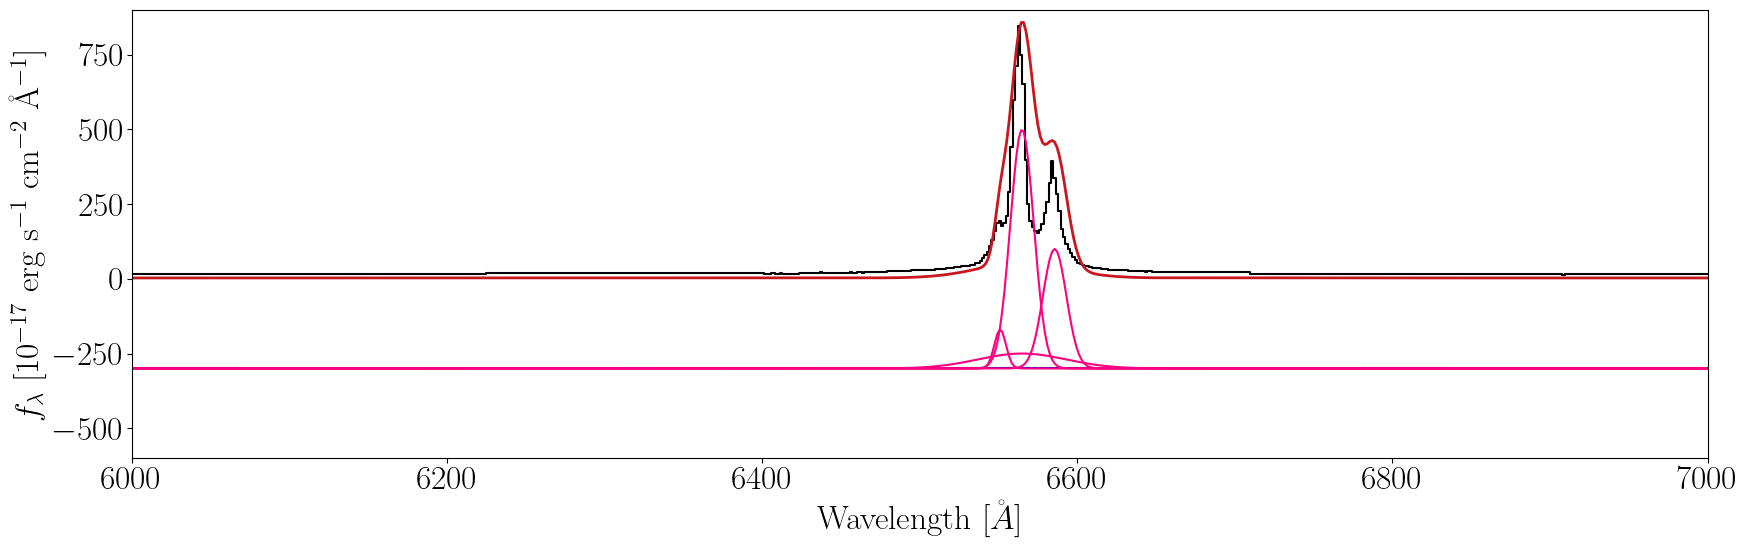

In [180]:
best_model = optical_agn_spectrum(lam,*guesses,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-600,900,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)

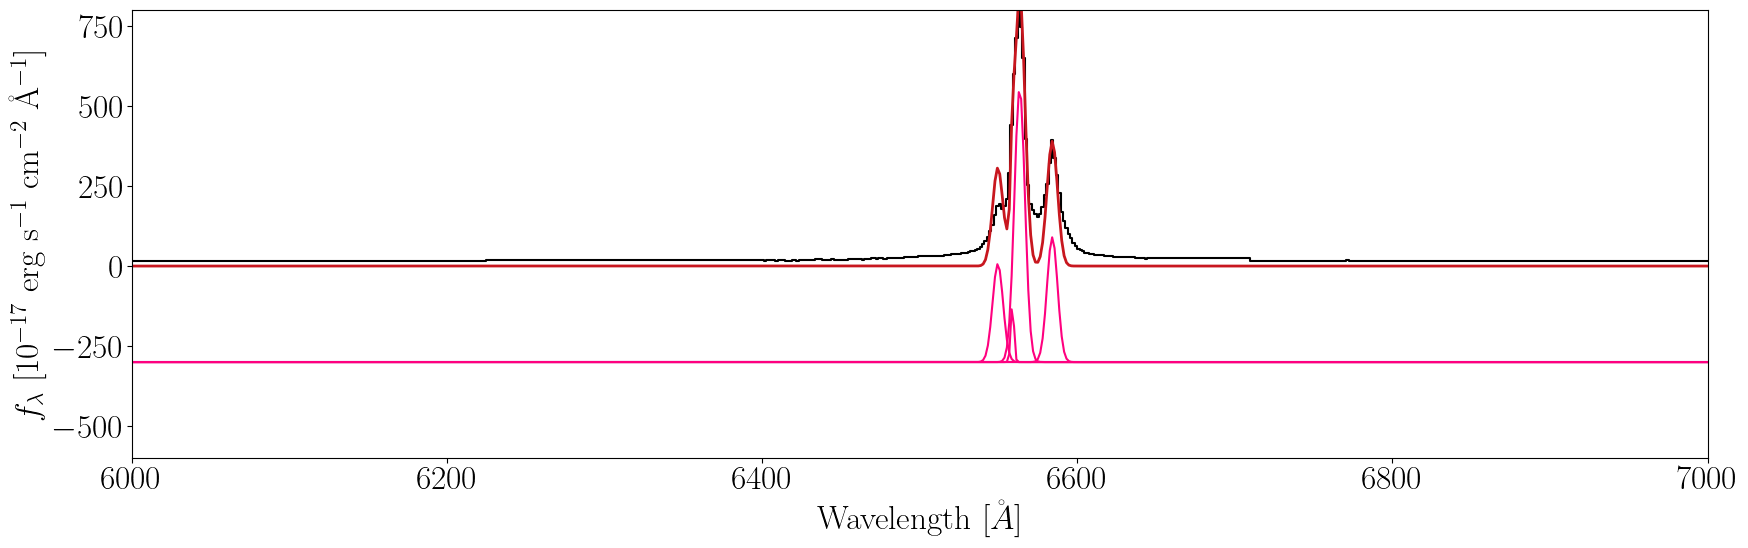

In [181]:
best_model = optical_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_optical_agn_fit(lam,flux,best_model,6000,7000,-600,800,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=6000,xmax=7000,ymin=-1,ymax=800,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()